---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---


# Hyperparameter Tuning of a Transformer Network with PyTorch Lightning {#sec-hyperparameter-tuning-with-pytorch-lightning-603}

## Basic Setup {#sec-basic-setup-601}

This section provides an overview of the hyperparameter tuning process using `spotpython` and `PyTorch` Lightning. It uses the `Diabetes` data set (see @sec-a-05-diabetes-data-set) for a regression task. 
@sec-light-user-data-601 describes how user data can be used in the hyperparameter tuning process.
@sec-light-user-model-601 explains how user models can be used in the hyperparameter tuning process.


In [1]:
#| echo: false
#| label: 603_imports
import numpy as np
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

In this section, we will show how `spotpython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.
It demonstrates how easy it is to use `spotpython` to tune hyperparameters for a `PyTorch` Lightning model.

After importing the necessary libraries, the `fun_control` dictionary is set up via the `fun_control_init` function.
The `fun_control` dictionary contains

* `PREFIX`: a unique identifier for the experiment
* `fun_evals`: the number of function evaluations
* `max_time`: the maximum run time in minutes
* `data_set`: the data set. Here we use the `Diabetes` data set that is provided by `spotpython`.
* `core_model_name`: the class name of the neural network model. This neural network model is provided by `spotpython`.
* `hyperdict`: the hyperparameter dictionary. This dictionary is used to define the hyperparameters of the neural network model. It is also provided by `spotpython`.
* `_L_in`: the number of input features. Since the `Diabetes` data set has 10 features, `_L_in` is set to 10.
* `_L_out`: the number of output features. Since we want to predict a single value, `_L_out` is set to 1.

The method `set_hyperparameter` allows the user to modify default hyperparameter settings. Here we set the `initialization` method to `["Default"]`. No other initializations are used in this experiment.
The `HyperLight` class is used to define the objective function `fun`. It connects the `PyTorch` and the `spotpython` methods and is provided by `spotpython`.
Finally, a `Spot` object is created.


In [2]:
#| label: 603_setup
from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.spot import spot
from spotpython.utils.file import get_experiment_filename
from spotpython.utils.scaler import TorchStandardScaler

fun_control = fun_control_init(
    PREFIX="603",
    TENSORBOARD_CLEAN=True,
    tensorboard_log=True,
    fun_evals=inf,
    max_time=1,
    data_set = Diabetes(),
    scaler=TorchStandardScaler(),
    core_model_name="light.regression.NNTransformerRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

set_hyperparameter(fun_control, "optimizer", [
                "Adadelta",
                "Adagrad",
                "Adam",
                "AdamW",
                "Adamax",
            ])
set_hyperparameter(fun_control, "epochs", [5, 7])
set_hyperparameter(fun_control, "nhead", [1, 2])
set_hyperparameter(fun_control, "dim_feedforward_mult", [1, 1])

design_control = design_control_init(init_size=5)
surrogate_control = surrogate_control_init(
    noise=True,
    min_Lambda=1e-3,
    max_Lambda=10,
)

fun = HyperLight().fun

spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control, surrogate_control=surrogate_control)

Seed set to 123


Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2024_09_22_16_30_17
Created spot_tensorboard_path: runs/spot_logs/603_p215209_2024-09-22_16-30-17 for SummaryWriter()
module_name: light
submodule_name: regression
model_name: NNTransformerRegressor


We can take a look at the design table to see the initial design.

In [3]:
#| label: 603_design_table
print(gen_design_table(fun_control))

| name                 | type   | default        |   lower |   upper | transform             |
|----------------------|--------|----------------|---------|---------|-----------------------|
| d_model_mult         | int    | 4              |    1    |     9   | transform_power_2_int |
| nhead                | int    | 3              |    1    |     2   | transform_power_2_int |
| num_encoder_layers   | int    | 1              |    1    |     4   | transform_power_2_int |
| dim_feedforward_mult | int    | 1              |    1    |     1   | transform_power_2_int |
| epochs               | int    | 7              |    5    |     7   | transform_power_2_int |
| batch_size           | int    | 5              |    5    |     8   | transform_power_2_int |
| optimizer            | factor | Adam           |    0    |     4   | None                  |
| dropout              | float  | 0.1            |    0.01 |     0.1 | None                  |
| lr_mult              | float  | 0.1            |

If we want to run the hyperparameter tuning process on a remote server, we can save the setting as a `pickle` file and load it on the remote server.


In [4]:
#| label: 603_save_experiment
filename = get_experiment_filename(fun_control["PREFIX"])
# if userExperimnents directory does not exist, create it
if not os.path.exists("userExperiment"):
    os.makedirs("userExperiment")
filename = os.path.join("userExperiment", filename)
if spot_tuner.spot_writer is not None:
    spot_tuner.spot_writer.close()
# remove attribute spot_writer from spot_tuner object
if hasattr(spot_tuner, "spot_writer"):
    delattr(spot_tuner, "spot_writer")
spot_tuner.save_experiment(filename=filename)

Calling the method `run()` starts the hyperparameter tuning process on the local machine.


In [5]:
#| label: 603_run
res = spot_tuner.run()

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes       | Out sizes     
-----------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 176    | train | [128, 10]      | [128, 16]     
1 | positional_encoding | PositionalEncoding | 0      | train | [128, 16]      | [128, 128, 16]
2 | transformer_encoder | TransformerEncoder | 17.8 K | train | [128, 128, 16] | [128, 128, 16]
3 | fc_out              | Linear             | 17     | train | [128, 16]      | [128, 1]      
-----------------------------------------------------------------------------------------------------
18.0 K    Trainable params
0         Non-trainable params
18.0 K    Total params
0.072     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


d_model: 16, dim_feedforward: 32
Milestones: [16, 32, 48]


`Trainer.fit` stopped: `max_epochs=64` reached.


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes       | Out sizes     
-----------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 11.3 K | train | [32, 10]       | [32, 1024]    
1 | positional_encoding | PositionalEncoding | 0      | train | [32, 1024]     | [32, 32, 1024]
2 | transformer_encoder | TransformerEncoder | 33.6 M | train | [32, 32, 1024] | [32, 32, 1024]
3 | fc_out              | Linear             | 1.0 K  | train | [32, 1024]     | [32, 1]       
-----------------------------------------------------------------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.447   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23737.96484375, 'hp_metric': 23737.96484375}
d_model: 1024, dim_feedforward: 2048
Milestones: [32, 64, 96]


`Trainer.fit` stopped: `max_epochs=128` reached.


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes        | Out sizes      
-------------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 1.4 K  | train | [128, 10]       | [128, 128]     
1 | positional_encoding | PositionalEncoding | 0      | train | [128, 128]      | [128, 128, 128]
2 | transformer_encoder | TransformerEncoder | 1.1 M  | train | [128, 128, 128] | [128, 128, 128]
3 | fc_out              | Linear             | 129    | train | [128, 128]      | [128, 1]       
-------------------------------------------------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.246     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 10616.478515625, 'hp_metric': 10616.478515625}
d_model: 128, dim_feedforward: 256
Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes      | Out sizes    
---------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 1.4 K  | train | [64, 10]      | [64, 128]    
1 | positional_encoding | PositionalEncoding | 0      | train | [64, 128]     | [64, 64, 128]
2 | transformer_encoder | TransformerEncoder | 2.1 M  | train | [64, 64, 128] | [64, 64, 128]
3 | fc_out              | Linear             | 129    | train | [64, 128]     | [64, 1]      
---------------------------------------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.485     Total estimated model params size (MB)
165       Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 22227.37109375, 'hp_metric': 22227.37109375}
d_model: 128, dim_feedforward: 256
Milestones: [8, 16, 24]


`Trainer.fit` stopped: `max_epochs=32` reached.


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes      | Out sizes    
---------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 88     | train | [256, 10]     | [256, 8]     
1 | positional_encoding | PositionalEncoding | 0      | train | [256, 8]      | [256, 256, 8]
2 | transformer_encoder | TransformerEncoder | 1.2 K  | train | [256, 256, 8] | [256, 256, 8]
3 | fc_out              | Linear             | 9      | train | [256, 8]      | [256, 1]     
---------------------------------------------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23569.638671875, 'hp_metric': 23569.638671875}
d_model: 8, dim_feedforward: 16
Milestones: [16, 32, 48]


`Trainer.fit` stopped: `max_epochs=64` reached.


train_model result: {'val_loss': 24153.24609375, 'hp_metric': 24153.24609375}
d_model: 1024, dim_feedforward: 2048


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes       | Out sizes     
-----------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 11.3 K | train | [32, 10]       | [32, 1024]    
1 | positional_encoding | PositionalEncoding | 0      | train | [32, 1024]     | [32, 32, 1024]
2 | transformer_encoder | TransformerEncoder | 33.6 M | train | [32, 32, 1024] | [32, 32, 1024]
3 | fc_out              | Linear             | 1.0 K  | train | [32, 1024]     | [32, 1]       
-----------------------------------------------------------------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.447   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


`Trainer.fit` stopped: `max_epochs=128` reached.


train_model result: {'val_loss': 10587.416015625, 'hp_metric': 10587.416015625}


spotpython tuning: 10587.416015625 [#########-] 85.40% 


d_model: 1024, dim_feedforward: 2048


GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs



  | Name                | Type               | Params | Mode  | In sizes       | Out sizes     
-----------------------------------------------------------------------------------------------------
0 | input_proj          | Linear             | 11.3 K | train | [32, 10]       | [32, 1024]    
1 | positional_encoding | PositionalEncoding | 0      | train | [32, 1024]     | [32, 32, 1024]
2 | transformer_encoder | TransformerEncoder | 33.6 M | train | [32, 32, 1024] | [32, 32, 1024]
3 | fc_out              | Linear             | 1.0 K  | train | [32, 1024]     | [32, 1]       
-----------------------------------------------------------------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.447   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Milestones: [32, 64, 96]


`Trainer.fit` stopped: `max_epochs=128` reached.


train_model result: {'val_loss': 10459.6484375, 'hp_metric': 10459.6484375}


spotpython tuning: 10459.6484375 [##########] 100.00% Done...



Note that we have enabled Tensorboard-Logging, so we can visualize the results with Tensorboard. Execute the
following command in the terminal to start Tensorboard.


In [6]:
#| label: 603_tensorboard
#| eval: false
tensorboard --logdir="runs/"

## Looking at the Results

### Tuning Progress

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.


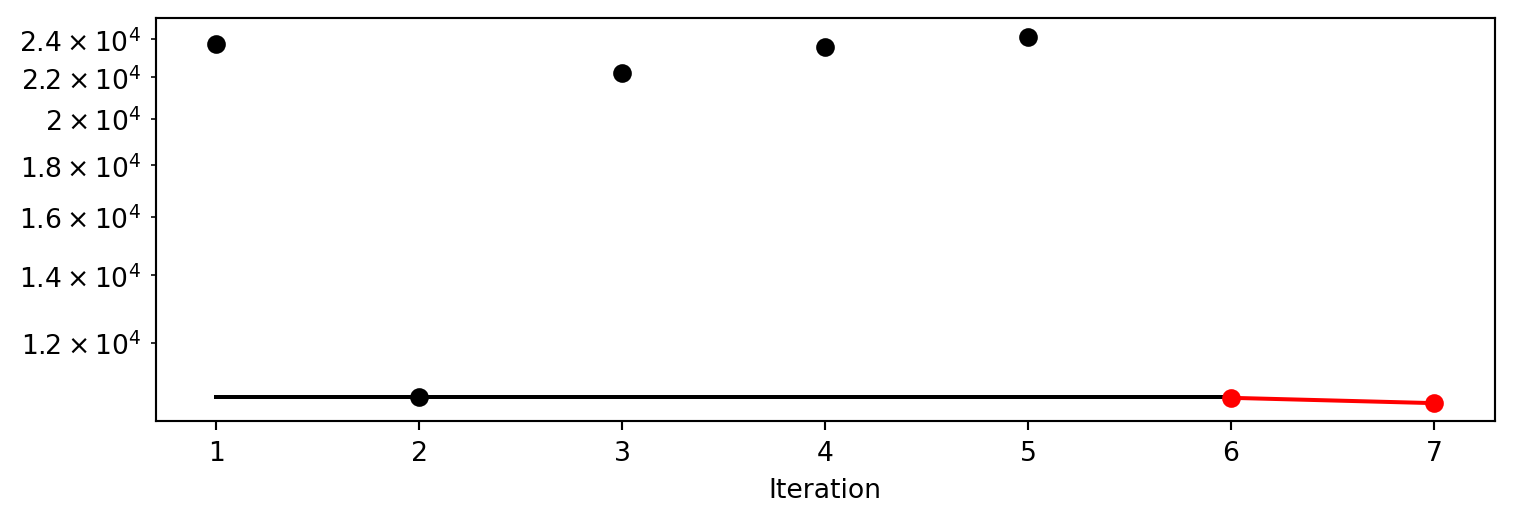

In [7]:
#| label: 603_plot_progress
spot_tuner.plot_progress(log_y=True, filename=None)

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.


In [8]:
#| label: 603_gen_design_table_results
from spotpython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                 | type   | default        |   lower |   upper | tuned               | transform             |   importance | stars   |
|----------------------|--------|----------------|---------|---------|---------------------|-----------------------|--------------|---------|
| d_model_mult         | int    | 4              |     1.0 |     9.0 | 8.0                 | transform_power_2_int |         0.00 |         |
| nhead                | int    | 3              |     1.0 |     2.0 | 2.0                 | transform_power_2_int |         0.04 |         |
| num_encoder_layers   | int    | 1              |     1.0 |     4.0 | 2.0                 | transform_power_2_int |         0.00 |         |
| dim_feedforward_mult | int    | 1              |     1.0 |     1.0 | 1.0                 | transform_power_2_int |         0.00 |         |
| epochs               | int    | 7              |     5.0 |     7.0 | 7.0                 | transform_power_2_int |       100.00 | ***     |
| batc

A histogram can be used to visualize the most important hyperparameters.


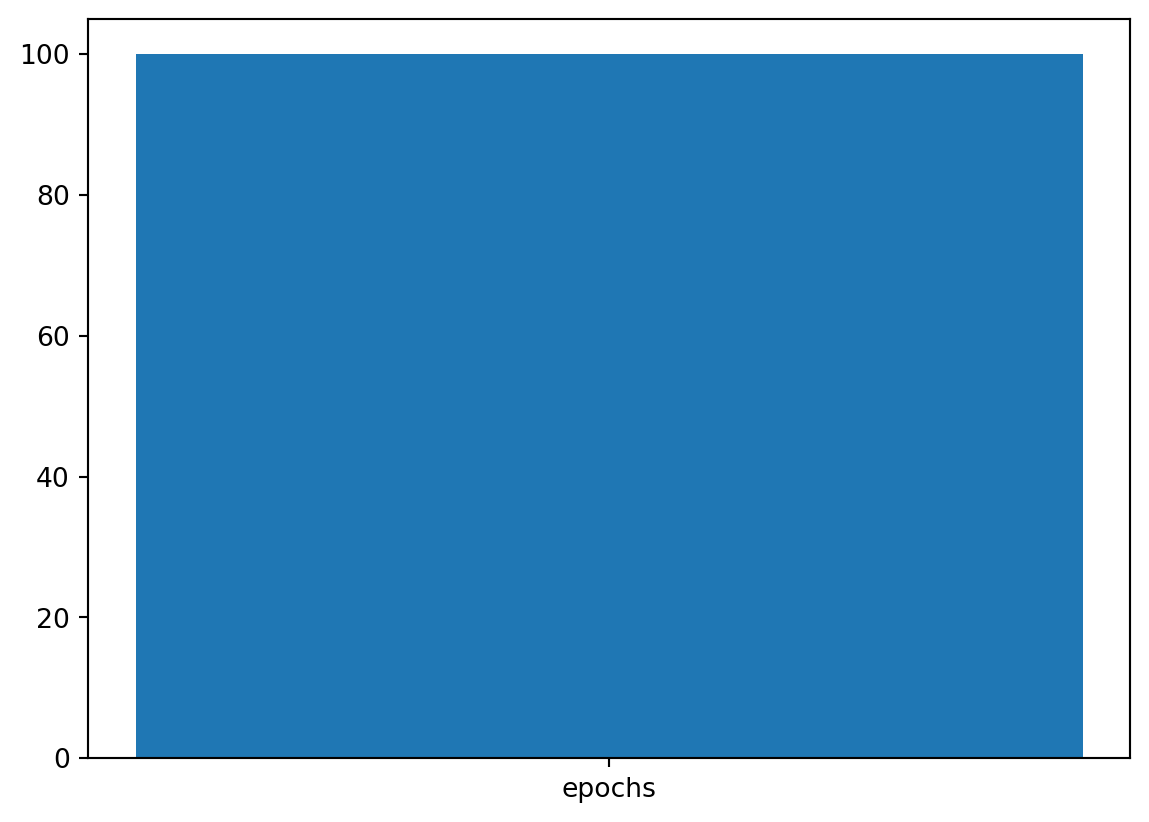

In [9]:
#| label: 603_plot_importance
spot_tuner.plot_importance(threshold=1.0)

## Hyperparameter Considerations

1. `d_model` (or `d_embedding`):

   - This is the dimension of the embedding space or the number of expected features in the input.
   - All input features are projected into this dimensional space before entering the transformer encoder.
   - This dimension must be divisible by `nhead` since each head in the multi-head attention mechanism will process a subset of `d_model/nhead` features.

2. `nhead`:

   - This is the number of attention heads in the multi-head attention mechanism.
   - It allows the transformer to jointly attend to information from different representation subspaces.
   - It's important that `d_model % nhead == 0` to ensure the dimensions are evenly split among the heads.

3. `num_encoder_layers`:

   - This specifies the number of transformer encoder layers stacked together.
   - Each layer contains a multi-head attention mechanism followed by position-wise feedforward layers.

4. `dim_feedforward`:

   - This is the dimension of the feedforward network model within the transformer encoder layer.
   - Typically, this dimension is larger than `d_model` (e.g., 2048 for a Transformer model with `d_model=512`).

### Important: Constraints and Interconnections:

- `d_model` and `nhead`:
  - As mentioned, `d_model` must be divisible by `nhead`. This is critical because each attention head operates simultaneously on a part of the embedding, so `d_model/nhead` should be an integer.

- `num_encoder_layers` and `dim_feedforward`**: 
  - These parameters are more flexible and can be chosen independently of `d_model` and `nhead`.
  - However, the choice of `dim_feedforward` does influence the computational cost and model capacity, as larger dimensions allow learning more complex representations. 

- One hyperparameter does not strictly need to be a multiple of others except for ensuring `d_model % nhead == 0`.

### Practical Considerations:

1. Setting `d_model`:

   - Common choices for `d_model` are powers of 2 (e.g., 256, 512, 1024).
   - Ensure that it matches the size of the input data after the linear projection layer.

2. Setting `nhead`:

   - Typically, values are 1, 2, 4, 8, etc., depending on the `d_model` value.
   - Each head works on a subset of features, so `d_model / nhead` should be large enough to be meaningful.

3. Setting `num_encoder_layers`:

   - Practical values range from 1 to 12 or more depending on the depth desired.
   - Deeper models can capture more complex patterns but are also more computationally intensive.

4. Setting `dim_feedforward`:

   - Often set to a multiple of `d_model`, such as 2048 when `d_model` is 512.
   - Ensures sufficient capacity in the intermediate layers for complex feature transformations.


::: {.callout-note}
### Note: `d_model` Calculation 

Since `d_model % nhead == 0` is a critical constraint to ensure that the multi-head attention mechanism can operate effectively, `spotpython` computes the value of `d_model` based on the `nhead` value provided by the user. This ensures that the hyperparameter configuration is valid. So, the final value of `d_model` is a multiple of `nhead`.
`spotpython` uses the hyperparameter `d_model_mult` to determine the multiple of `nhead` to use for `d_model`, i.e., `d_model = nhead * d_model_mult`.
:::

::: {.callout-note}
### Note: `dim_feedforward` Calculation

Since this dimension is typically larger than `d_model` (e.g., 2048 for a Transformer model with `d_model=512`),
`spotpython` uses the hyperparameter `dim_feedforward_mult` to determine the multiple of `d_model` to use for `dim_feedforward`, i.e., `dim_feedforward = d_model * dim_feedforward_mult`.

::: 

## Summary

This section presented an introduction to the basic setup of hyperparameter tuning of a transformer with `spotpython` and `PyTorch` Lightning.